In [2]:
import torch
from torch import nn
import time
import torch.nn.functional as F
import matplotlib.pyplot as plt
import dlc_practical_prologue as prologue

In [3]:
#直接导入出现http403错误
from six.moves import urllib
# 直接导入出现http403错误
# have to add a header to your urllib request (due to that site moving to Cloudflare protection)
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)
#*********************** 

In [4]:
N_PAIRS = 1000
train_input, train_target, train_classes, test_input, test_target, test_classes = prologue.generate_pair_sets(N_PAIRS)

In [5]:
print(train_input.shape)
print(train_classes.shape)
print(train_target.shape)
print(test_input.shape)
print(test_classes.shape)
print(test_target.shape)

torch.Size([1000, 2, 14, 14])
torch.Size([1000, 2])
torch.Size([1000])
torch.Size([1000, 2, 14, 14])
torch.Size([1000, 2])
torch.Size([1000])


In [8]:
train_input[0].shape

torch.Size([2, 14, 14])

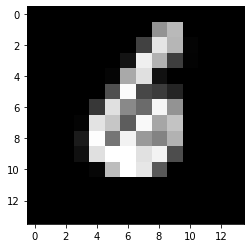

In [27]:
plt.imshow(train_input[0][0],cmap='gray')
plt.show()

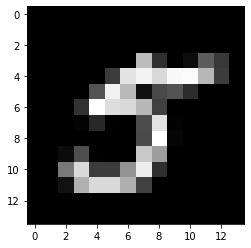

In [28]:
plt.imshow(train_input[0][1],cmap='gray')
plt.show()

In [29]:
# 将两个图片拼接成一个1*392的tensor，为进入MLP网络进行准备。
print(train_input.shape)
tran_train_input=train_input.view(-1,2*14*14)
print(tran_train_input.shape)

torch.Size([1000, 2, 14, 14])
torch.Size([1000, 392])


In [30]:
#同理对测试数据集进行相同的操作
tran_test_input=test_input.view(-1,2*14*14)
print(tran_test_input.shape)

torch.Size([1000, 392])


In [31]:
# class MLP_Net(nn.Module):
#     def __init__(self, num_hidden_1,num_hidden_2,num_hidden_3,num_hidden_4):
#         super(Test_MLPmodel, self).__init__()
#         self.linear1 = nn.Linear(2*14*14, 300)
#         self.linear2 = nn.Linear(300, 200)
#         self.linear3 = nn.Linear (200, 100)
#         self.linear4 = nn.Linear (100, 50)
#         self.linear_out = nn.Linear(num_hidden_4,2)

#     def forward(self, x):
#         x = F.relu(self.linear1(x.view(-1,2*14*14)))
#         x = F.relu(self.linear2(x))
#         x = F.relu(self.linear3(x))
#         x = F.relu(self.linear4(x))
#         x = self.linear_out(x)       
#         return x

In [32]:
class MLP_Net(nn.Module):
    def __init__(self):
        super(MLP_Net, self).__init__()
        self.linear1 = nn.Linear(2*14*14, 300)
        self.linear2 = nn.Linear(300, 200)
        self.linear3 = nn.Linear (200, 100)
        self.linear4 = nn.Linear (100, 50)
        self.linear5 = nn.Linear (50, 20)
        self.linear_out = nn.Linear(20,2)
        # training parameter
        self.batch_size = 20
        self.criterion = nn.CrossEntropyLoss()
        self.num_epochs = 25
        self.optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)

    def forward(self, x):
        x = F.relu(self.linear1(x.view(-1,2*14*14)))
        x = F.relu(self.linear2(x))
        x = F.relu(self.linear3(x))
        x = F.relu(self.linear4(x))
        x = F.relu(self.linear5(x))
        x = self.linear_out(x)       
        return x
     # Training Function

    def trainer(self, train_input, train_target):
        """
        Train the model on a training set
        :param train_input: Training features
        :param train_target: Training labels
        """
        start_time = time.time()
        self.train()
        for epoch in range(self.num_epochs):
            for batch_idx in range(0,train_input.size(0),self.batch_size):
                output = self(train_input[batch_idx:batch_idx+self.batch_size]) 
                loss = self.criterion(output, train_target[batch_idx:batch_idx+self.batch_size])  
                self.optimizer.zero_grad()                          #清零梯度
                loss.backward()                                #反向求梯度
                self.optimizer.step()

                if not batch_idx % 50:
                    print ('Epoch: %03d/%03d | Batch %03d/%03d | Loss: %.6f' 
                           %(epoch+1, self.num_epochs, batch_idx, 
                             len(train_input), loss))
            print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

        print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))
         # Test error

    def compute_error(self, input_data, target):
        """
        Compute the number of error of the model on a test set
        :param input_data: test features
        :param target: test target
        :return: error rate of the input data
        """  
    
        #测试模型
        self.eval()      #测试模式，关闭正则化
        errors = 0
        for idx in range(0,input_data.size(0),self.batch_size):
            input_batch=input_data.narrow(0,idx,self.batch_size)
            outputs = self(input_batch)
            _, predicted = torch.max(outputs, 1)   #返回值和索引
            target_labels = target.narrow(0, idx, self.batch_size)
            errors += torch.sum(predicted != target_labels)

        return float(errors)*100/input_data.size(0)
    def save_model(self,model_name):
        """
        Save the model to this folder
        :param model_name: the model name, e.g. CNN_Net.pth
        """         
        torch.save(self, './model/'+model_name)

In [33]:
my_model = MLP_Net()
my_model.save_model('MLP_Net.pth')

In [34]:
# train the model
my_model.trainer(train_input, train_target)

Epoch: 001/025 | Batch 000/1000 | Loss: 0.627910
Epoch: 001/025 | Batch 100/1000 | Loss: 0.665862
Epoch: 001/025 | Batch 200/1000 | Loss: 0.547835
Epoch: 001/025 | Batch 300/1000 | Loss: 0.445861
Epoch: 001/025 | Batch 400/1000 | Loss: 0.457809
Epoch: 001/025 | Batch 500/1000 | Loss: 0.501272
Epoch: 001/025 | Batch 600/1000 | Loss: 0.610885
Epoch: 001/025 | Batch 700/1000 | Loss: 0.630210
Epoch: 001/025 | Batch 800/1000 | Loss: 0.478961
Epoch: 001/025 | Batch 900/1000 | Loss: 0.437284
Time elapsed: 0.00 min
Epoch: 002/025 | Batch 000/1000 | Loss: 0.344189
Epoch: 002/025 | Batch 100/1000 | Loss: 0.331104
Epoch: 002/025 | Batch 200/1000 | Loss: 0.342556
Epoch: 002/025 | Batch 300/1000 | Loss: 0.400370
Epoch: 002/025 | Batch 400/1000 | Loss: 0.274455
Epoch: 002/025 | Batch 500/1000 | Loss: 0.286864
Epoch: 002/025 | Batch 600/1000 | Loss: 0.429386
Epoch: 002/025 | Batch 700/1000 | Loss: 0.682405
Epoch: 002/025 | Batch 800/1000 | Loss: 0.324944
Epoch: 002/025 | Batch 900/1000 | Loss: 0.2705

Epoch: 017/025 | Batch 400/1000 | Loss: 0.000986
Epoch: 017/025 | Batch 500/1000 | Loss: 0.002208
Epoch: 017/025 | Batch 600/1000 | Loss: 0.000938
Epoch: 017/025 | Batch 700/1000 | Loss: 0.002532
Epoch: 017/025 | Batch 800/1000 | Loss: 0.006642
Epoch: 017/025 | Batch 900/1000 | Loss: 0.000069
Time elapsed: 0.03 min
Epoch: 018/025 | Batch 000/1000 | Loss: 0.000067
Epoch: 018/025 | Batch 100/1000 | Loss: 0.001301
Epoch: 018/025 | Batch 200/1000 | Loss: 0.000424
Epoch: 018/025 | Batch 300/1000 | Loss: 0.000138
Epoch: 018/025 | Batch 400/1000 | Loss: 0.000046
Epoch: 018/025 | Batch 500/1000 | Loss: 0.000062
Epoch: 018/025 | Batch 600/1000 | Loss: 0.000433
Epoch: 018/025 | Batch 700/1000 | Loss: 0.000094
Epoch: 018/025 | Batch 800/1000 | Loss: 0.000403
Epoch: 018/025 | Batch 900/1000 | Loss: 0.000032
Time elapsed: 0.03 min
Epoch: 019/025 | Batch 000/1000 | Loss: 0.000040
Epoch: 019/025 | Batch 100/1000 | Loss: 0.000605
Epoch: 019/025 | Batch 200/1000 | Loss: 0.000149
Epoch: 019/025 | Batch 

In [35]:
# output the train error and test error
print("Train error : %.1f%% \nTest error : %.1f%%" %
      (my_model.compute_error(train_input, train_target),
       my_model.compute_error(test_input, test_target)))

print("The total number of the parameters is: %d" % (sum(p.numel() for p in my_model.parameters())))

Train error : 0.0% 
Test error : 18.0%
The total number of the parameters is: 204312


In [54]:
# def compute_accuracy(net, test_input,test_target):
# # 在训练模型的时候前面加上model.train()，在测试模型的时候前面加上model.eval(),以切换到测试模式
#     net.eval()
#     correct_pred, num_examples = 0, 0
# # 而with torch.no_grad()则主要是用于停止autograd模块的工作，
# # 以起到加速和节省显存的作用，具体行为就是停止gradient计算，
# # 从而节省了GPU算力和显存，但是并不会影响dropout和batchnorm层的行为。
#     with torch.no_grad():
# #         for features, targets in data_loader:
#         for idx in range(test_input.size(0)):
# #             features = features.view(-1, 14*14)
#             features= test_input[idx]
#             targets = test_target[idx]
#             logits, probas = net(features)
#             _, predicted_labels = torch.max(probas, 1)
#             num_examples += targets.size(0)
#             correct_pred += (predicted_labels == targets).sum()
#         return correct_pred.float()/num_examples * 100